<a href="https://colab.research.google.com/github/Filipe-Miguel/CAS/blob/main/Copy_of_Course_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2022

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 1.

# Load libraries

In [3]:
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt
import seaborn as sns
#sns.set()

from time import time as timer
from imageio import imread
import pandas as pd
import numpy as np
import os

from sklearn.manifold import TSNE

import tensorflow as tf
import tarfile

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [4]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 53.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=ba485f0cbb4fdf8474f28508702064ed4d28d1f0157b20cbf70aef2bc62f85bf
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=aa78f80ce763b66cd5387b18767f3a29bb4d405030a0d71d6532cd9b1c96be38
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [7]:
! rm colab_material.tgz

rm: cannot remove 'colab_material.tgz': No such file or directory


In [12]:
! ls data

AmesHousing.csv  AmesHousing.txt  responses.csv


In [8]:
import umap

In [10]:
#if not os.path.exists('data'):
path = os.path.abspath('.')+'/colab_material.tgz'
tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
tar = tarfile.open(path, "r:gz")
tar.extractall()
tar.close()

In [11]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [ ]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))
  
  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

In [ ]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')
plt.show()

In [ ]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)
plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [ ]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)
  
  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)
  
  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()                              
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [ ]:
def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)
    
    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)
    
    return features_scaled

In [ ]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

In [ ]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

In [ ]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 6. Weather dataset

This is a weather time series [dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the Max Planck Institute for Biogeochemistry 
It contains weather reacord for 8 years of observation.

In [ ]:
def get_weather_df():
  # inspired by https://www.tensorflow.org/tutorials/structured_data/time_series

  # download and extract dataset
  zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
  csv_path, _ = os.path.splitext(zip_path)

  # load into pandas df
  df = pd.read_csv(csv_path)
  
  # dataset contains records every 10 min, we use hourly records only, thus
  # slice [start:stop:step], starting from index 5 take every 6th record
  df = df[5::6]

  # replace errors in wind velocity to 0
  wv = df['wv (m/s)']
  bad_wv = wv == -9999.0
  wv[bad_wv] = 0.0

  max_wv = df['max. wv (m/s)']
  bad_max_wv = max_wv == -9999.0
  max_wv[bad_max_wv] = 0.0

  # obtain timestamps from text time format
  date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  # genarate cyclic features for year and day
  day = 24*60*60
  year = (365.2425) * day

  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  return df

In [ ]:
weather_df = get_weather_df()

In [ ]:
weather_df.head()

In [ ]:
weather_df.describe().T

In [ ]:
plt.plot(weather_df['Year cos'])
plt.plot(weather_df['Year sin'])

In [ ]:
plt.plot(weather_df['Day cos'][:7*24])
plt.plot(weather_df['Day sin'][:7*24])

In [ ]:
def gen_future_T_dataset(X_len=24, Y_offset=48,
                         X_features=['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
                         Y_features='T (degC)',
                         standardize=True,
                         oversample=10
                         ):
  """
  Generates pairs of input-label, using sequence of `X_len` samples as input
  and value at offset `Y_offset` from start of this sequence as label.
  Sample sequnces arte taken at random positions throughout the dataset.
  Number of samples is obtained assuming non-overlaping wondows.
  Oversampling factor allows to increase this value.

  Args:
    X_len (int): length of sample sequence
    Y_offset (int): offset to the target value from the sequence start
    X_features (list or str): features to be used as input
    Y_features (list or str): features to be used as labels
    standardize (Bool): flag whether to standardize the columns
    oversample (int): increases number of samples by this factor wrt baseline
                      n = len(df) // (Y_offset+1)
  """
  weather_df = get_weather_df()

  if standardize:
    mean = weather_df.mean()
    std = weather_df.std()
    weather_df = (weather_df - mean) / std
  
  df_X = weather_df[X_features]
  df_Y = weather_df[Y_features]

  n_records = len(df_X)
  sample_len = Y_offset+1
  n_samples = int((n_records-sample_len)//sample_len*oversample)
  offsets = np.random.randint(0, n_records-sample_len, size=n_samples)
  offsets.sort()

  X = []
  Y = []
  for o in offsets:
    X.append(np.array(df_X[o:o+X_len]))
    Y.append(np.array(df_Y[o+Y_offset:o+Y_offset+1]))

  X = np.stack(X)
  Y = np.concatenate(Y)

  return X, Y

In [ ]:
x, y = gen_future_T_dataset()

In [ ]:
x.shape, y.shape

In [ ]:
for f,fn in enumerate(['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos']):
  plt.figure(figsize=(5*(1+(f==1)), 4))
  for s in range(10):
    plt.plot(x[s, :, f])
    if f==1:
      plt.scatter(48, y[s], color=plt.gca().lines[-1].get_color())
  plt.title(fn)
  plt.show()

# 1. Unsupervised Learning Techniques


Unsupervised learning technique different from supervised ones from the fact that data are not labelled.

We do not aim at fitting a mapping from $X$ to $y$, but to understand pattern in the data cloud $X$.

## 1. Principal Component Analysis (PCA)

Let's start with the example that we will use to make the theory more concrete. We will take a dataset from from kaggle https://www.kaggle.com/datasets/miroslavsabo/young-people-survey?resource=download (already downloaded for you in the folder `data`)

The datasets consists of the results of a survey about the music preferences of several students, arriving at the following dataset:

In [13]:
data=pd.read_csv("data/responses.csv")

In [14]:
data

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,5.0,2.0,5.0,2.0,2.0,5.0,4.0,4.0,4.0,3.0,...,20.0,164.0,57.0,1.0,female,right handed,secondary school,no,city,house/bungalow
1006,4.0,4.0,5.0,1.0,3.0,4.0,1.0,4.0,1.0,1.0,...,27.0,183.0,80.0,5.0,male,left handed,masters degree,no,village,house/bungalow
1007,4.0,3.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,1.0,...,18.0,173.0,75.0,0.0,female,right handed,secondary school,yes,city,block of flats
1008,5.0,3.0,3.0,3.0,1.0,3.0,1.0,3.0,4.0,1.0,...,25.0,173.0,58.0,1.0,female,right handed,college/bachelor degree,no,city,block of flats


In [15]:
music_columns=data.columns[:19]
print(music_columns)
music_data=data[music_columns].dropna()

Index(['Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country',
       'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
       'Punk', 'Hiphop, Rap', 'Reggae, Ska', 'Swing, Jazz', 'Rock n roll',
       'Alternative', 'Latino', 'Techno, Trance', 'Opera'],
      dtype='object')


The answers are of course correlated and we expect to have typical patterns recurring, that we define as people liking similar types of songs. 

The patterns may be also mixing, for e.g. a class of people may like classic `Pop` and `Reggae`, but not `Latino`. An other class may like `Latino` and `Reggae`, but not `Pop`.

PCA will help to find these typical patterns and their number in a data driven fashion. As we will see these patterns will naturally appear when trying to compress data in a lower dimensional space.

### Theory overview.

We will start looking at PCA from the point of view of `dimensionaliy reduction`.

We can have different starting points

**Objective:** PCA is used for dimensionality reduction when we have a large number $D$ of features with non-trivial intercorrelation ( data redundancy ) and to isolate relevant features. The number of features $D$ defines the original dimension of the dataset. Each sample defines a vector of dimensionality $D$.


    QUESTION: what are the starting vectors in our survey dataset? How many do we have?

PCA provides a new set of $M$ uncorrelated features for every data point, with $M \le D$. The new features are:

- a linear combination of the original ones ; (can consider only linear relationships)
- uncorrelated between each other ; 

If $M \ll D$ we get an effective dimensionality reduction.

    QUESTION: Does the number of data points changes after applying PCA?

**Methods:** Each data point indexed by $p=1..N$ can be seen as an element $\mathbf{x}_p \in \mathbf{R}^D$. Note that we can define an addition element-wise between the data-points (vector addition).

The variance of the data-cloud measures the spread around its centroid:

$$S^2=\frac{1}{N}\sum_{p=1}^{N}  | \mathbf{x}_p - \mathbf{\overline{x}}|^2$$
$$\mathbf{\overline{x}}=\frac{1}{N}\sum_{p=1}^{N} \mathbf{x}_p$$

The centroid is the mean. The distance to the mean will be calculated. We want to project conserving as much as possible the variamnce.


We fix a number $1\le k \le D$ and consider a subspace $V_k$ of dimension $k$. To visualize at first consider $D=3$ (our space), and $k=1,2$. $k=1$ takes into considerations lines, $k=2$ planes.

Given $V_k$ we can perform the following steps:

1. Projekt each data point  $\mathbf{x}_p$ onto $V_k$, leading to points $\mathbf{x}^k_p$. Projecting a point $\mathbf{x}_p$ is equivalent to getting the point $\mathbf{x}^k_p$ belonging to $V_k$ and closest to $\mathbf{x}_p$.

2. Use the previous formula to evaluate $S^{2,k}$, the spread of the projected data cloud.

This is exemplified below in the left figure.

Now, depending on $V_k$ we get a difference variance. PCA chooses $V_k$ such that the variance $S^{2,k}$ is maximized, as shown in the picture on the right. The nice thing is that the subspace $V_k$ can be evaluated analytically, given any data cloud.

It is a linear technique, so will projects in plains. Chooses a plain, projects the points. Calculates a centroid and calculates the distance from the centroid (red). It conserves as much as possible the variance. 



<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/pca-theory.png" width="100%"/>

PCA describes subspaces (lines,planes, and their high dimensional generalizations) as "generated" by a sequence of vectors $v_1,...,v_k$. This is defined as the set of all the vectors:

$$V_{\{v_1,...,v_k\}}=\{ \alpha_1 v_1+...+\alpha_k v_k, \alpha_1,..., \alpha_k \in \mathbf{R} \}$$

Acima é uma sequência de vectores. Uma linha é descrita pelo valor e a multiplicação, para a tornar numa linha. 

PCA will therefore provide a sequence of vectors. Since many choices of $\{v_1,...,v_k\}$ could describe the same "line", "plane", etc. etc., it imposes an orthonormality condition.




**Terminology and output of a PCA computation:** 
- `Principal components`: A sequence of orthonormal vectors $k_1,..,k_n$. We can interpret these vectors as the typical patterns found in the data, from increasing to decreasing probability of appearance. Any vector can be constructed as a linear combination of such patterns. Using only the first $m$ vectors we get a "best approximation".

    
- `Scores`: For every sample-point $p$, the new features are called scores are given by the component of $p$ along the $k$ vectors;  


- `Reconstructed vector`: For every $k$, the projection of $V$ on $V_k$. This is the best approximation that we can get of the vector using only $k$ vectors (principal components).


- `Explained variance`: For every k, the ratio between the variance of the reconstructed vectors and total variance. The number of components is chosen selecting an optimal k. The plot of the explained variance as a function of k is called a *scree plot* - o mais próximo de 1

    QUESTION: 
    What are the main differences between a vector $x_p$ and a principal component $k_n$? In particular:
    1) how many do we have ? xp describes our dataset. P is the sample point. We have as many as the samples for the first. Instead, the pca, k_n, se projectar uma linha temos um componente. Temos o mesmo número de componentes qhe o número de colunas
    2) what are their dimensions ? sao iguais
    
    QUESTION: 
    What are the differences between $x_p$ and a score vector $s_p$? In particular:
    1) how many do we have ? 
    2) what are their dimensions ?
    
    QUESTION: 
    1) How many reconstructed vectors do we have? What is their dimension ? Can we have a reconstructed vector with zero error? se tivermos um linear subspace que projecte exactamente não perdemos nenhum; uma aplicação de pca também serve para remover barulho. Quando fazemos a projecção podemos remover barulho. 

### Sklearn: implementation and usage of PCA.


https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

We start showing a two-dimensional example that can be easy visualized.

We load the datasets that we are going to use for the examples:

We have  30 samples of dimension  2


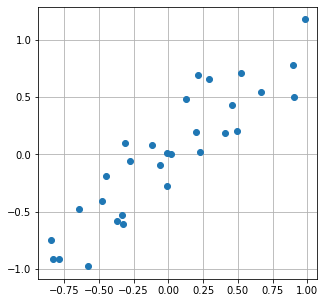

In [16]:
data=load_sample_data_pca()

n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')
plt.show()

The data set is almost one dimensional. PCA will confirm this result.

As with most of sklearn functionalities, we need first to create a PCA object. We will use the object methods to perform PCA.

In [18]:
pca=PCA(n_components=2) 

A call to the pca.fit method computes the principal components

In [19]:
pca.fit(data)

PCA(n_components=2)

In [ ]:
dir(pca) #ver os atributos

Now the pca.components_ attribute contains the principal components. We can print them alongside with the data and check that they constitute an orthonormal basis.

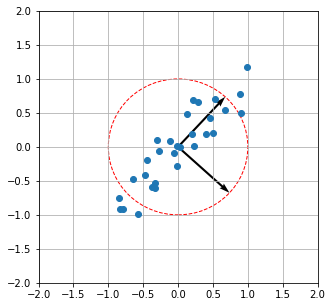

In [22]:
plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

circle=plt.Circle((0, 0), 1.0, linestyle='--', color='red',fill=False)
ax=plt.gca()
ax.add_artist(circle)

for vec in pca.components_:
    plt.quiver([0], [0], [vec[0]], [vec[1]], angles='xy', scale_units='xy', scale=1) #the black lines are the first and second principal component; the first one is the one é o que acompanha a direcção dos dados
    #o segundo pode ser para medir o  barulho

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

The pca.explained_variance_ratio_ attribute contains the explained variance. In this case we see that already the first reconstructed vector explains 95% of the variance.

In [ ]:
print(pca.explained_variance_ratio_) #há um número para casa componente; a percentagem de varância que é explicada pelo primero e pelo segundo; neste caso só vale a pena 
#manter o primeiro, o segundo tem um valor muito baixo 

[0.95140729 0.04859271]


To compute the reconstructed vectors for k=1 we first need to compute the scores and then multiply by the basis vectors:

$\mathbf x_{rec}=\sum_i (\mathbf x \cdot \mathbf v^{pr}_i) \mathbf v^{pr}_i$

Fórmula matemática para descontruir o vector

In [23]:
k=1 #se quisermos o vector decomposto só com o primeiro componente
scores=pca.transform(data)
res=np.dot(scores[:,:k], pca.components_[:k,:] )

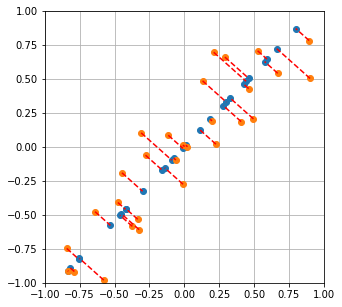

In [24]:
plt.figure(figsize=((5,5)))
plt.plot(res[:,0],res[:,1],'o')
plt.plot(data[:,0],data[:,1],'o')

for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
    plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

plt.grid()

plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.show()

#visualização dos pontos projectados (azul - reconstructed vector) e o barulho. Os tracejados são a distância entre os pontos iniciais e o reconstruído

The same procedure is followed for high dimensional datasets. Here we generate random data which lies almost on a 6-dimensional subspace. The resulting scree plot can be used to find this result in a semi-automatic fashion.

Let's redo the same now with our survey dataset, to review the concepts again and think "high"-dimensionally.

In [25]:
pca=PCA() 
pca.fit(music_data)

PCA()

Text(0.5, 0, 'Princial component')

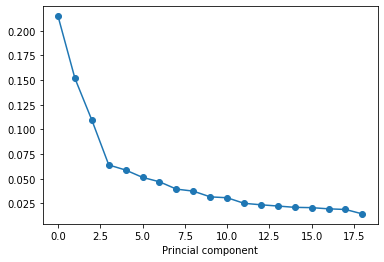

In [27]:
plt.plot(pca.explained_variance_ratio_,'-o')
plt.xlabel("Princial component")
#só 20% da variância pode ser explicada por um componente; há medida que vamos adicionando componentes, vamos explicando mais variância; o segundo componente explica mais 15%
#os primeiros 4 têm um comportamento diferente dos outros, pelo que vale a pena usar só  usar os 4 primeiros; se formos até todos os componentes a soma tem que ser 1

In [30]:
df = pd.DataFrame(pca.components_.transpose(), 
                  columns = [f'V_{i+1}' for i in range(len(music_columns))], 
                  index=music_columns)
df
#plot verticalmente o primeiro componente

,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,V_10,V_11,V_12,V_13,V_14,V_15,V_16,V_17,V_18,V_19
Music,0.034327,-0.030242,-0.058575,0.003401,-0.005648,0.070442,-0.072589,0.046377,-0.002965,-0.044203,0.005060,-0.112661,0.011120,0.114572,0.140985,-0.138319,-0.223307,0.223824,-0.902855
Slow songs or fast songs,-0.038844,0.001008,-0.150553,0.058194,-0.098439,0.037892,0.008159,-0.023107,-0.106553,0.048223,0.046499,-0.469155,-0.196216,0.302002,0.408006,-0.491768,0.244483,0.258269,0.245515
Dance,-0.108185,-0.351080,-0.242687,0.144840,-0.215340,0.140691,0.072253,0.150583,-0.106101,-0.007872,-0.225787,-0.284248,-0.454947,-0.441326,0.126784,0.223653,-0.171112,-0.224983,-0.016402
Folk,0.198776,-0.190829,0.165786,0.110605,-0.005172,-0.214301,0.350442,0.290317,-0.367466,-0.340010,-0.047813,-0.350712,0.189948,0.291911,-0.329439,0.068718,-0.136498,-0.024515,0.040103
Country,0.170824,-0.140712,0.074469,0.013157,-0.127616,-0.205966,0.493252,0.371091,0.024814,0.188480,0.321041,0.317403,0.049683,-0.341773,0.253690,-0.175941,0.060453,0.217247,-0.013842
Classical music,0.321165,-0.154089,0.246121,0.335864,0.050521,-0.112244,-0.242079,0.058894,0.227351,-0.237305,-0.084052,0.144460,-0.040855,0.015306,0.203028,-0.416664,-0.063652,-0.515503,-0.006618
Musical,0.195235,-0.315976,0.227786,-0.189421,-0.212367,-0.041638,-0.419096,-0.113744,-0.242206,0.473885,0.297234,-0.237463,0.195298,-0.144131,-0.132668,-0.080119,-0.153356,-0.055279,0.037238
Pop,-0.102153,-0.323553,-0.093759,-0.191536,-0.354285,0.196396,-0.257379,0.313967,0.084972,-0.267280,-0.222586,0.120422,0.331245,-0.039526,-0.088276,-0.056829,0.484205,0.097763,-0.038331
Rock,0.307950,0.116657,-0.196066,-0.138037,-0.298001,0.155711,-0.095854,0.090328,0.178293,-0.158085,-0.070379,0.057146,0.217821,0.127137,0.302390,0.159884,-0.586401,0.189754,0.279609
Metal or Hardrock,0.337369,0.277790,-0.224637,0.107211,-0.356716,-0.218770,0.118212,-0.386633,0.140126,-0.183835,0.168455,-0.283392,0.181362,-0.251764,-0.013434,0.139735,0.303840,-0.133485,-0.142317


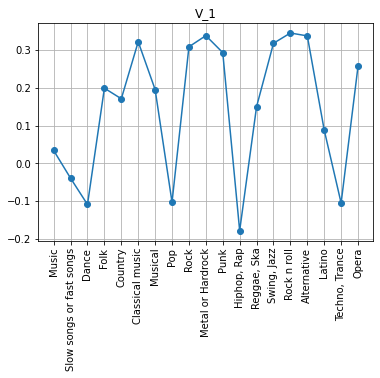

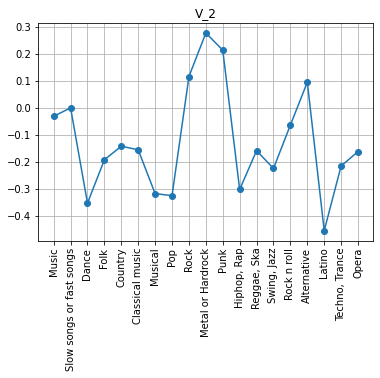

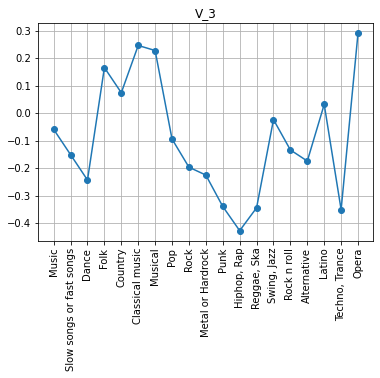

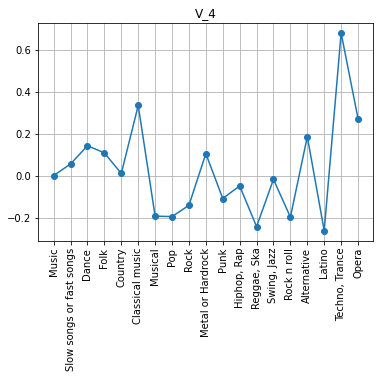

In [29]:
for vector in ['V_1','V_2','V_3','V_4']:
    plt.figure()
    plt.title(vector)
    plt.plot(np.arange(len(music_columns)),list(df[vector]),'-o')
    _=plt.xticks(np.arange(len(music_columns)),music_columns, rotation=90)
    plt.grid()

    #visualizar desta maneira os vectores; valores negativos e positivos para a maneira como os tipos de música influenciam as pontuações
    #diferentes componentes e vemos como os tipos de música podem ser agrupados conforme os gostos

### EXERCISE 1 : Find the dimensionality of the hidden dataset.

In [ ]:
# In this exercise you will take a custom high dimensional dataset and try to find its dimensionality 

# 1. Load the data using the function data=load_multidimensional_data_pca() , check the dimensionality of the data and plot them.
data=...
n_samples,n_dim=... 
print('We have ',n_samples, 'samples of dimension ', n_dim)

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca....

# 3. Check the explained variance ratio and select best number of components.
print(pca...)
plt.plot(...)


### EXERCISE 2 : Find the hidden drawing.

In [ ]:
### In this exercise you will take a high dimensional dataset, find the optimal number of principal components 
# and see what plot do we get if we visualize in a 2D plot the first two scores.

# 1. Load the data using the function data=load_ex2_data_pca(seed=1235) , check the dimensionality of the data and plot them.
data=...
n_samples,n_dim=... 
print('We have ',n_samples, 'samples of dimension ', n_dim)

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca....

# 3. Check the explained variance ratio and select best number of components.
print(pca...)
plt.plot(...)

# 4. Plot the reconstructed vectors for the best value of data=...
k=...
data_transformed=...
plt.plot(data_transformed[:,...],data_transformed[:,...],'o')
plt.xlabel('First component')
plt.ylabel('Second component')

### EXERCISE 3 (bonus) : 

In [ ]:
# Explore more the survey dataset. Suppose you have studied the first vectors and found 
# some 4 types of music advertisment, targetted to the 4 classes of clients.

# Given a customer, how would you choose which advertisement to send him?

### Final comments:

PCA is able therefore to make this mapping:

$(x_1,...,x_D) \rightarrow (y_1,..,y_M)$

Here we focused on data compression, but it is also very important that $y_1,...,y_M$ are uncorrolated for interpratibility purposes. Being uncorrelated means (roughly) that in our dataset we can change one variable without affecting the others. The dimensions 1,...,M are often therefore more interpretable and providing more information.

See e.g. a similar application here:

"Principal component analysis of dietary and lifestyle patterns in relation to risk of subtypes of esophageal and gastric cancer", https://pubmed.ncbi.nlm.nih.gov/21435900/

, where each data point $x$ is an answer from a questionnaire of food. The principal components are than typical "patterns" of answers that are uncorrlated, have a look at table 2, and if you want read the whole data story :)

## 2. Data visualization and embedding in low dimensions ( t-SNE / UMAP )

### Theory overview

PCA is a linear embedding technique where the scores are a linear function of the original variables. This forces the number of principal components to be used to be high, if the manifold is highly non-linear. Curved manifolds need to be embedded in higher dimensions.

Other `non-linear` embedding techniques start from a local description of the environment of each sample point in the original space:

- `t-Sne` uses a `statistical description` of the environment of a sample point ;
- `UMAP` describes the `topology` of the environment through a generalized "triangulation" (simplex decomposition) ;

The projection on the low-dimensional space is optimized in order to match as much as possible the description of the local environment. 

It is not the goal of this introduction to discuss the derivation of such approaches, which can be found in the references:

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

https://arxiv.org/pdf/1802.03426.pdf



Instead, the following, we will show how to apply practically these dimensionality reductions techniques. Keep in mind that the embedding is given by an iterative solution of a minimization problem and therefore the results may depend on the value of the random seed, especially for t-SNE visualizazions.

### Utilization in Python and examples

To begin with, we create a t-SNE object that we are going to use.

In [ ]:
tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
                      n_iter=2000, random_state=2233212, metric='euclidean', verbose=100 )

umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

### Example 1: Exercise 3 Cont'd

We will first visualize our multi-dimensional heart using t-SNE: 

In [ ]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
                      n_iter=300, random_state=2233212, metric='euclidean', verbose=1 )

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.001s...
[t-SNE] Computed neighbors for 651 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.060286


/home/arismarcolongo/miniconda3/envs/selective_search/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 10.369261
[t-SNE] KL divergence after 300 iterations: 0.602112


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from utils.routines import *
import matplotlib.pyplot as plt

X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3, verbose=1).fit_transform(X)
X_embedded.shape

[t-SNE] Computing 3 nearest neighbors...
[t-SNE] Indexed 4 samples in 0.000s...
[t-SNE] Computed neighbors for 4 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 4 / 4
[t-SNE] Mean sigma: 12.094863
[t-SNE] KL divergence after 250 iterations with early exaggeration: 33.738800
[t-SNE] KL divergence after 1000 iterations: 0.047805


(4, 2)

In [ ]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=1)

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.001s...
[t-SNE] Computed neighbors for 651 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.025506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.112373
[t-SNE] KL divergence after 1000 iterations: 0.924472


In [ ]:
plt.scatter(tsne_heart[:,0],tsne_heart[:,1])
plt.show()

And using UMAP :

In [ ]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

umap_hart = umap_model.fit_transform(data)
plt.scatter(umap_hart[:, 0], umap_hart[:, 1])
plt.show()

### Example 2: Mnist dataset

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=10, n_components=2, learning_rate=200,
#                   early_exaggeration=4.0,init='pca', 
#                   n_iter=2000, random_state=2233212, 
#                   metric='euclidean', verbose=100, n_jobs=1)

# tsne_mnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_mnist[:,0],tsne_mnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_mnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/mnist.png" width="100%"/> |
 |  -----:| -----:|

In [ ]:
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(data)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=labels, s=10)
plt.show()

### Example 3: Fashion_Mnist dataset

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=50, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
#                      n_iter=1000, random_state=2233212, metric='euclidean', verbose=100 )

# tsne_fmnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_fmnist[:,0],tsne_fmnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_fmnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/fmnist.png" width="100%"/> 
 |  -----:| -----:|

In [ ]:
umap_model = umap.UMAP(n_neighbors=50, n_components=2, random_state=1711)
umap_fmnist = umap_model.fit_transform(data)
plt.scatter(umap_fmnist[:, 0], umap_fmnist[:, 1], c=labels, s=10)
plt.show()

### Example 4: House prices

In [ ]:
data=house_prices_dataset_normed()

In [ ]:
# not to run on COLAB

#tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200,
#                  early_exaggeration=4.0,init='pca', n_iter=1000,
#                  random_state=2233212, metric='euclidean', verbose=100)

#tsne_houses = tsne_model.fit_transform(data)

#plt.scatter(tsne_houses[:,0],tsne_houses[:,1],s=20)
#plt.savefig('t_sne_houses.png')
# plt.show()

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_houses.png" width="50%"/>

In [ ]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)
plt.show()

**Message:** Visualization techniques are useful for having an initial grasp of multi-dimensional datasets and guide further analysis and the choice of the modelling data strategy.

**Caveats:** 
- available t-SNE implementations may vary a lot in terms of performance. Computational time can be reduced performing PCA before a t-SNE projection

- UMAP, thanks to the algorithm being amanable to clever initializations and optimization schemes, offers great stability and scaling properties

- UMAP, even if starting from a local picture, is generally more able to spread apart different clusters

- The result of an embedding may depend on the values of the metaparameters. One should try to see how the final embedding changes in order to get to a complete picture